## In this notebook we will modeling play by play yac data


In [1]:
#Read in data/ install packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pathlib import Path

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
#Lets first get all of our data into pandas dataframes
games = pd.read_csv('data/games.csv')
players = pd.read_csv('data/players.csv')
plays = pd.read_csv('data/plays.csv')
tackles = pd.read_csv('data/tackles.csv')
# Assuming your tracking data files are named tracking_week_1.csv, tracking_week_2.csv, ..., tracking_week_9.csv
data_dir = Path("data/")  # Update with the correct path
tracking_dfs = sorted(data_dir.glob("tracking_week_*.csv"))

# Create an empty list to store individual week dataframes
week_dfs = []

# Iterate through each tracking data file and load it into a dataframe
for week_number, tracking_file in enumerate(tracking_dfs, start=1):
    week_df = pd.read_csv(tracking_file)
    
    # Add a 'week' column with the corresponding week number
    week_df['week'] = week_number
    
    # Append the dataframe to the list
    week_dfs.append(week_df)

# Combine all week dataframes into a single dataframe
tracking = pd.concat(week_dfs, ignore_index=True)


In [4]:
#Filter out any non-pass plays
yac_df = plays[plays.passResult == 'C'][['gameId','playId','ballCarrierId','ballCarrierDisplayName','yardsToGo','possessionTeam','defensiveTeam','yardlineSide','yardlineNumber']]
yac_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber
0,2022100908,3537,48723,Parker Hesse,10,ATL,TB,ATL,41
2,2022091111,1148,42547,Darren Waller,5,LV,LAC,LV,30
5,2022103001,2165,54616,Tyler Allgeier,17,ATL,CAR,ATL,18
9,2022092511,2903,46096,Rashaad Penny,10,SEA,ATL,SEA,25
12,2022091102,3336,46331,Ross Dwelley,10,SF,CHI,SF,25
...,...,...,...,...,...,...,...,...,...
12472,2022092500,2194,41292,Jarvis Landry,10,NO,CAR,NO,22
12478,2022100213,811,40011,Travis Kelce,2,KC,TB,KC,26
12479,2022092504,2509,52725,Ben Ellefson,10,MIN,DET,MIN,23
12480,2022100910,105,44959,George Kittle,6,SF,CAR,SF,29


In [5]:
#Get rid of any plays that do not include a 'first_contact' frame
plays_with_first_contact = tracking[tracking['event'] == 'first_contact'][['gameId', 'playId']].drop_duplicates()
yac_df = yac_df[
    yac_df.set_index(['gameId', 'playId']).index.isin(plays_with_first_contact.set_index(['gameId', 'playId']).index)
]
yac_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber
0,2022100908,3537,48723,Parker Hesse,10,ATL,TB,ATL,41
2,2022091111,1148,42547,Darren Waller,5,LV,LAC,LV,30
5,2022103001,2165,54616,Tyler Allgeier,17,ATL,CAR,ATL,18
9,2022092511,2903,46096,Rashaad Penny,10,SEA,ATL,SEA,25
15,2022100212,1183,46109,Courtland Sutton,16,DEN,LV,LV,18
...,...,...,...,...,...,...,...,...,...
12467,2022091110,2925,39983,Zach Ertz,10,ARI,KC,ARI,25
12469,2022092507,310,43334,Derrick Henry,10,TEN,LV,LV,11
12478,2022100213,811,40011,Travis Kelce,2,KC,TB,KC,26
12479,2022092504,2509,52725,Ben Ellefson,10,MIN,DET,MIN,23


## Calculate yards gained after the 'first_contact' frame

In [6]:
def yards_after_contact(row, tracking):
    gameId = row['gameId']
    playId = row['playId']
    ballCarrierId = row['ballCarrierId']
    
    selected_tracking = tracking[(tracking.gameId == gameId) & (tracking.playId == playId) & (tracking.nflId == ballCarrierId)]

    # Check if there are matching rows
    if not selected_tracking.empty:
        first_contact_row = selected_tracking.loc[selected_tracking.event == 'first_contact', 'x']
        tackle_row = selected_tracking.loc[selected_tracking.event == 'tackle', 'x']

        # Check if rows with 'first_contact' and 'tackle' events exist
        if not first_contact_row.empty and not tackle_row.empty:
            x_first_contact = first_contact_row.values[0]
            x_tackle = tackle_row.values[0]

            play_direction = selected_tracking['playDirection'].values[0]

            if play_direction == 'right':
                yards_gained = x_tackle - x_first_contact
            else:
                yards_gained = x_first_contact - x_tackle

            # Forward progress rule
            yards_gained = max(0, yards_gained)
        else:
            # If events are not found, set yards_gained to 0
            yards_gained = 0
    else:
        # If no matching rows are found, set yards_gained to 0
        yards_gained = 0

    return yards_gained


In [7]:
yac_df['yards_after_contact'] = yac_df.apply(yards_after_contact, args=(tracking,), axis=1)
yac_df

C:\Users\cquin\AppData\Local\Temp\ipykernel_16024\2108386957.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yac_df['yards_after_contact'] = yac_df.apply(yards_after_contact, args=(tracking,), axis=1)


,gameId,playId,ballCarrierId,ballCarrierDisplayName,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,yards_after_contact
0,2022100908,3537,48723,Parker Hesse,10,ATL,TB,ATL,41,0.30
2,2022091111,1148,42547,Darren Waller,5,LV,LAC,LV,30,1.52
5,2022103001,2165,54616,Tyler Allgeier,17,ATL,CAR,ATL,18,1.12
9,2022092511,2903,46096,Rashaad Penny,10,SEA,ATL,SEA,25,1.71
15,2022100212,1183,46109,Courtland Sutton,16,DEN,LV,LV,18,0.00
...,...,...,...,...,...,...,...,...,...,...
12467,2022091110,2925,39983,Zach Ertz,10,ARI,KC,ARI,25,0.75
12469,2022092507,310,43334,Derrick Henry,10,TEN,LV,LV,11,1.53
12478,2022100213,811,40011,Travis Kelce,2,KC,TB,KC,26,1.81
12479,2022092504,2509,52725,Ben Ellefson,10,MIN,DET,MIN,23,0.77


## Which defender made first contact?
I will determine this by calculating the euclidean distance between all defenders and the ballcarrier at the frame of first contact. I will then drop any plays in which the labelled "first defender" is not accredited with a tackle in the tackles dataframe

In [8]:
tracking_fc = pd.merge(tracking, plays[['gameId','playId', 'ballCarrierId', 'defensiveTeam']], on = ['gameId','playId'], how='left')


# Drop rows with NaN values in the 'nflId' column
tracking_fc.dropna(subset=['nflId'], inplace=True)

tracking_fc['nflId'] = pd.to_numeric(tracking_fc['nflId'], errors='coerce').astype(int)

tracking_fc = tracking_fc[(tracking_fc.nflId == tracking_fc.ballCarrierId) | (tracking_fc.club == tracking_fc.defensiveTeam)]
tracking_fc = tracking_fc[
    tracking_fc.set_index(['gameId', 'playId']).index.isin(yac_df.set_index(['gameId', 'playId']).index)
]

tracking_fc = pd.merge(tracking_fc, yac_df[['gameId','playId','ballCarrierDisplayName','yardsToGo','yards_after_contact']], on = ['gameId','playId'], how='left')

In [9]:
# Merge DataFrames based on gameId, playId, and nflId
tracking_fc = pd.merge(tracking_fc, tackles[['gameId', 'playId', 'nflId']], 
                     on=['gameId', 'playId', 'nflId'], how='left', indicator=True)

# Add a new column 'involved_in_tackle' with 1 if there is a match and 0 otherwise
tracking_fc['involved_in_tackle'] = (tracking_fc['_merge'] == 'both').astype(int)

# Drop the indicator column and any other columns introduced by the merge
tracking_fc.drop(['_merge'], axis=1, inplace=True)


In [10]:
import warnings

# Filter out all warnings
warnings.filterwarnings("ignore")

# Filter the DataFrame to include only frames with 'first_contact' event
caught_frames = tracking_fc[tracking_fc['event'] == 'first_contact']

# Add a new column 'defender_first_contact' to tracking_fc
tracking_fc['defender_first_contact'] = np.nan

# Iterate through unique pairs of gameId and playId
for (game_id, play_id) in caught_frames[['gameId', 'playId']].drop_duplicates().itertuples(index=False):
    # Get the data for the current gameId and playId
    play_data = caught_frames[(caught_frames['gameId'] == game_id) & (caught_frames['playId'] == play_id)]
    
    # Get the coordinates of the ballcarrier
    ballcarrier_coords = play_data[play_data['nflId'] == play_data['ballCarrierId']][['x', 'y']].values[0]
    
    # Calculate Euclidean distance for each defender
    play_data['distance_to_ballcarrier'] = play_data.apply(
        lambda row: np.linalg.norm([row['x'] - ballcarrier_coords[0], row['y'] - ballcarrier_coords[1]]),
        axis=1
    )
    
    # Exclude the ballcarrier from the candidates for first contact
    play_data = play_data[play_data['nflId'] != play_data['ballCarrierId']]
    
    # Find the defender with the minimum distance (first contact)
    defender_first_contact = play_data.loc[play_data['distance_to_ballcarrier'].idxmin()]['nflId']
    
    # Fill the 'defender_first_contact' value for all rows with the same 'gameId' and 'playId'
    tracking_fc.loc[(tracking_fc['gameId'] == game_id) & (tracking_fc['playId'] == play_id), 'defender_first_contact'] = defender_first_contact

# Now, tracking_fc DataFrame has a new column 'defender_first_contact' with the defender's nflId for each first contact event.


In [11]:
tracking_fc['defender_first_contact'] = tracking_fc['defender_first_contact'].astype(int)

In [12]:

yac_df = pd.merge(yac_df, tracking_fc[['gameId', 'playId', 'defender_first_contact']].drop_duplicates(),
                  on=['gameId', 'playId'], how='left')

yac_df.rename(columns={'defender_first_contact': 'nflId'}, inplace=True)

print(yac_df.shape[0])

#only include plays where the first defender is also listed in the tackles dataframe
yac_df = yac_df[
    yac_df.set_index(['gameId', 'playId', 'nflId']).index.isin(tackles.set_index(['gameId', 'playId', 'nflId']).index)
]

yac_df.rename(columns={'nflId': 'defender_first_contact'}, inplace=True)

print(yac_df.shape[0])

4291
3959


## Feature Engineering
Lets come up with some variables that are likely to impact the success of a tackle. We will calculate:
1. Avg speed of both players between the pass catch and the collision
2. Distance the players are from one another at the time the pass was caught
3. Difference in angle between the defender and offense (from the offense pov)
4. Height and Weight of both the ballcarrier and the defender

In [13]:
#Now let's find the position and speed of the first defender prior to the contact
def get_avg_speed(row, tracking_df, defender):
    gameId = row['gameId']
    playId = row['playId']
    defenderId = row['defender_first_contact']
    
    selected_tracking = tracking_df[(tracking_df.gameId == gameId) & (tracking_df.playId == playId)]

    # Get the frame when the pass was caught
    first_frame = selected_tracking[selected_tracking.event == 'pass_outcome_caught']['frameId'].values[0]
    last_frame = selected_tracking[selected_tracking.event == 'first_contact']['frameId'].values[0]
    numframes = last_frame - first_frame + 1

    speed_defender = 0
    speed_ballcarrier = 0
    
    for frame in range(first_frame, last_frame + 1):  # Use range to iterate over frames
        speed_defender += selected_tracking[(selected_tracking.frameId == frame) & (selected_tracking.nflId == defenderId)]['s'].values[0] / numframes
        speed_ballcarrier += selected_tracking[(selected_tracking.frameId == frame) & (selected_tracking.nflId == selected_tracking.ballCarrierId)]['s'].values[0] / numframes

    if defender:
        return speed_defender
    else:
        return speed_ballcarrier


In [14]:
#Get the average speed of both the ballcarrier and the defender
yac_df.loc[:, 'avg_speed_defender'] = yac_df.apply(get_avg_speed, args=(tracking_fc, True), axis=1)
yac_df.loc[:, 'avg_speed_ballcarrier'] = yac_df.apply(get_avg_speed, args=(tracking_fc, False), axis=1)


In [15]:
yac_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,yards_after_contact,defender_first_contact,avg_speed_defender,avg_speed_ballcarrier
0,2022100908,3537,48723,Parker Hesse,10,ATL,TB,ATL,41,0.30,43306,5.120000,2.730000
1,2022091111,1148,42547,Darren Waller,5,LV,LAC,LV,30,1.52,47843,5.296000,6.678000
2,2022103001,2165,54616,Tyler Allgeier,17,ATL,CAR,ATL,18,1.12,46124,5.929048,6.255714
3,2022092511,2903,46096,Rashaad Penny,10,SEA,ATL,SEA,25,1.71,52527,7.095714,5.520714
4,2022100212,1183,46109,Courtland Sutton,16,DEN,LV,LV,18,0.00,47810,4.410000,1.470000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4286,2022091110,2925,39983,Zach Ertz,10,ARI,KC,ARI,25,0.75,53487,3.129091,2.927273
4287,2022092507,310,43334,Derrick Henry,10,TEN,LV,LV,11,1.53,44968,4.153636,2.784545
4288,2022100213,811,40011,Travis Kelce,2,KC,TB,KC,26,1.81,40074,5.140000,1.712727
4289,2022092504,2509,52725,Ben Ellefson,10,MIN,DET,MIN,23,0.77,47929,9.516667,6.520000


In [16]:
#Get the distance from the ballcarrier at the time the pass was caught
def get_distance(row, tracking_df, event):
    gameId = row['gameId']
    playId = row['playId']
    defenderId = row['defender_first_contact']
    
    selected_tracking = tracking_df[(tracking_df.gameId == gameId) & (tracking_df.playId == playId)]
    
    x_ballcarrier = selected_tracking[(selected_tracking.event == event) & (selected_tracking.nflId == selected_tracking.ballCarrierId)]['x'].values[0]
    y_ballcarrier = selected_tracking[(selected_tracking.event == event) & (selected_tracking.nflId == selected_tracking.ballCarrierId)]['y'].values[0]
    x_defender = selected_tracking[(selected_tracking.event == event) & (selected_tracking.nflId == defenderId)]['x'].values[0]
    y_defender = selected_tracking[(selected_tracking.event == event) & (selected_tracking.nflId == defenderId)]['y'].values[0]
    return np.sqrt((x_defender - x_ballcarrier)**2 + (y_defender - y_ballcarrier)**2)


In [17]:
# Apply the function using iterrows()
yac_df.loc[:, 'distance_when_pass_caught'] = yac_df.apply(get_distance, args=(tracking_fc, 'pass_outcome_caught'), axis=1)


In [20]:
# Angle difference at first contact
def get_angles(row, tracking_df, event):
    gameId = row['gameId']
    playId = row['playId']
    defenderId = row['defender_first_contact']
    ballCarrierId = row['ballCarrierId']
    
    selected_tracking = tracking_df[(tracking_df.gameId == gameId) & (tracking_df.playId == playId)]
    angle_ballcarrier = selected_tracking[(selected_tracking.nflId == ballCarrierId) & (selected_tracking.event == event)]['o'].values[0]
    angle_defender = selected_tracking[(selected_tracking.nflId == defenderId) & (selected_tracking.event == event)]['o'].values[0]
    
    offense_angle = 0
    if selected_tracking['playDirection'].values[0] == 'left':
        offense_angle = 270
    else:
        offense_angle = 90
    
    raw_angle_difference = angle_defender - angle_ballcarrier
    standardized_angle_difference = (raw_angle_difference - offense_angle) % 360
    
    return standardized_angle_difference

In [21]:
yac_df.loc[:, 'angle_difference'] = yac_df.apply(get_angles, args=(tracking_fc, 'first_contact'), axis=1)

## Add player height and weights

In [23]:
players_defense = players[players.position.isin(['DE', 'NT', 'SS', 'FS', 'OLB', 'DT', 'CB', 'ILB', 'MLB', 'DB'])]
players_defense = players_defense.rename(columns={'nflId': 'defender_first_contact'})

players_offense = players[players.position.isin(['QB', 'T', 'TE', 'WR', 'G', 'C', 'RB', 'FB'])]
players_offense = players_offense.rename(columns={'nflId': 'ballCarrierId'})


# Merging Defense Information:
yac_df = pd.merge(yac_df, players_defense[['defender_first_contact', 'height', 'weight']],
                  on='defender_first_contact',
                  how='left')

# Rename Defense Columns:
yac_df = yac_df.rename(columns={'height': 'defender_height', 'weight': 'defender_weight'})

# Merging Offense Information:
yac_df = pd.merge(yac_df, players_offense[['ballCarrierId', 'height', 'weight']],
                  on='ballCarrierId',
                  how='left')

# Rename Offense Columns:
yac_df = yac_df.rename(columns={'height': 'offense_height', 'weight': 'offense_weight'})


In [24]:
#Convert height to inches
def height_to_inches(height_str):
    if height_str is None:
        return None
    
    feet, inches = height_str.split('-')
    total_inches = int(feet) * 12 + int(inches)
    return total_inches

yac_df['defender_height'] = yac_df['defender_height'].apply(height_to_inches)
yac_df['offense_height'] = yac_df['offense_height'].apply(height_to_inches)

## Let's add a "broken tackle" column to look at classification models as well as regression

In [46]:
tackles_2 = tackles.copy()
tackles_2 = tackles_2.rename(columns={'nflId': 'defender_first_contact'})

In [104]:
#If the ballcarrier gets 5 or more yards after contact, or is listed as a pff_missedTackle, we'll consider the tackle to be broken
yac_df = pd.merge(yac_df, tackles_2[['gameId', 'playId', 'defender_first_contact', 'pff_missedTackle']],
                       on=['gameId', 'playId', 'defender_first_contact'], how='left')

yac_df['broken_tackle'] = np.where((yac_df['yards_after_contact'] >= 5) | (yac_df['pff_missedTackle'] == 1), True, False)


## Now lets do some modeling
### Linear Regression 

Mean Squared Error: 7.350708669707365
R-squared: 0.02985684803932831


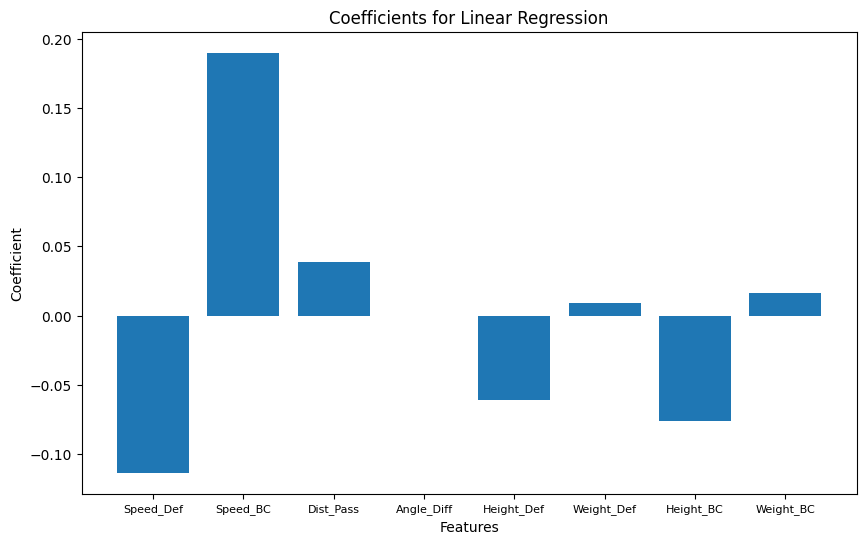

In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Selecting features (X) and target variable (y)
X_columns = ['avg_speed_defender', 'avg_speed_ballcarrier', 'distance_when_pass_caught',
             'angle_difference','defender_height', 'defender_weight', 'offense_height', 'offense_weight']

y_column = 'yards_after_contact'

X = yac_df[X_columns]
y = yac_df[y_column]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a linear regression model
model = LinearRegression()

# Training the model
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


# Getting coefficients
coefficients = model.coef_

# Creating a bar plot to visualize coefficients
plt.figure(figsize=(10, 6))
plt.bar(X_columns, coefficients)
custom_labels = ['Speed_Def', 'Speed_BC', 'Dist_Pass', 'Angle_Diff', 'Height_Def', 'Weight_Def', 'Height_BC', 'Weight_BC']
plt.xticks(X_columns, custom_labels, fontsize=8)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Coefficients for Linear Regression')
plt.show()

The mean squared error (MSE) of 7.35 and R-squared value of 0.03 suggest that the linear regression model has limited predictive accuracy, explaining only a small portion of the variance in the yards_after_contact. The low R-squared indicates that the chosen features might not be well-suited for capturing the variability in the target variable. Additionally, the coefficients provide insights into the feature importance; the negative coefficient for the speed of the defender and the positive coefficient for the speed of the offense suggest that the defender's speed has a slight negative impact, while the offense's speed has a positive impact on yards_after_contact. Further refinement of the model or exploration of additional features may be needed for improved predictive performance.

## LASSO Regression

Mean Squared Error with Lasso: 7.348704353340355
R-squared with Lasso: 0.030121376792294874


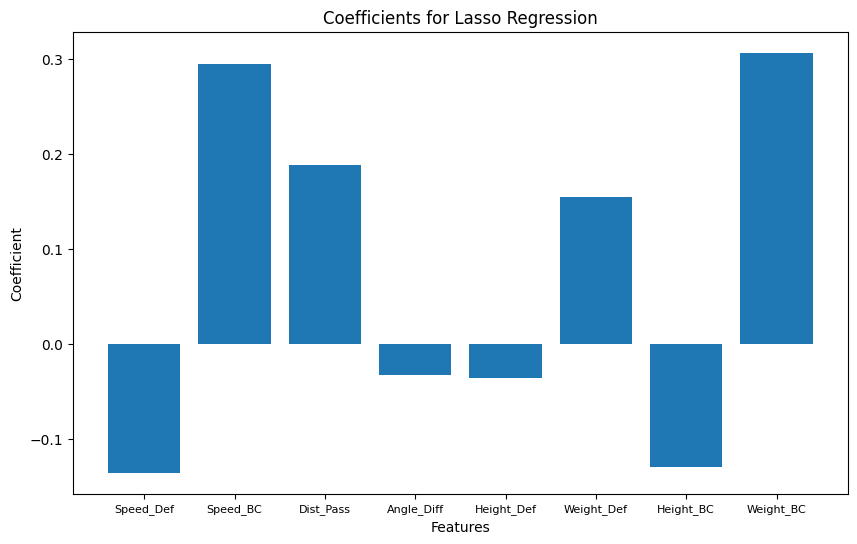

In [80]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Assuming your data is stored in a DataFrame named 'yac_df'
# Selecting features (X) and target variable (y)
X_columns = ['avg_speed_defender', 'avg_speed_ballcarrier', 'distance_when_pass_caught',
             'angle_difference', 'defender_height', 'defender_weight', 'offense_height', 'offense_weight']

y_column = 'yards_after_contact'

X = yac_df[X_columns]
y = yac_df[y_column]

# Standardize the features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42)

# Creating a Lasso regression model
lasso_model = Lasso(alpha=0.03)  # You may adjust the alpha parameter based on your preference

# Training the Lasso model
lasso_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_lasso = lasso_model.predict(X_test)

# Evaluating the Lasso model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f'Mean Squared Error with Lasso: {mse_lasso}')
print(f'R-squared with Lasso: {r2_lasso}')

# Getting coefficients
coefficients_lasso = lasso_model.coef_

# Creating a bar plot to visualize coefficients with Lasso
plt.figure(figsize=(10, 6))
plt.bar(X_columns, coefficients_lasso)
custom_labels = ['Speed_Def', 'Speed_BC', 'Dist_Pass', 'Angle_Diff', 'Height_Def', 'Weight_Def', 'Height_BC', 'Weight_BC']
plt.xticks(X_columns, custom_labels, fontsize=8)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Coefficients for Lasso Regression')
plt.show()


Applying Lasso regression to the model yielded a marginal improvement, with a slightly reduced mean squared error of 7.35 and a modest increase in R-squared to 0.03. The attempt to incorporate Lasso regularization was undertaken to address potential overfitting or multicollinearity, but the limited enhancement suggests that the initial linear model may not be prone to these issues, and further investigation into alternative model structures or feature engineering approaches might be necessary for more substantial improvements.

### Random Forest Regression

In [106]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Assuming your data is stored in a DataFrame named 'yac_df'
# Selecting features (X) and target variable (y)
X_columns2 = ['avg_speed_defender', 'avg_speed_ballcarrier', 'distance_when_pass_caught',
             'angle_difference', 'defender_height', 'defender_weight',
             'offense_height', 'offense_weight']

y_column = 'yards_after_contact'

X = yac_df[X_columns]
y = yac_df[y_column]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a Random Forest regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Training the model
rf_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluating the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Mean Squared Error (Random Forest): {mse_rf}')
print(f'R-squared (Random Forest): {r2_rf}')


Mean Squared Error (Random Forest): 7.754399157638889
R-squared (Random Forest): -0.023422037028228093


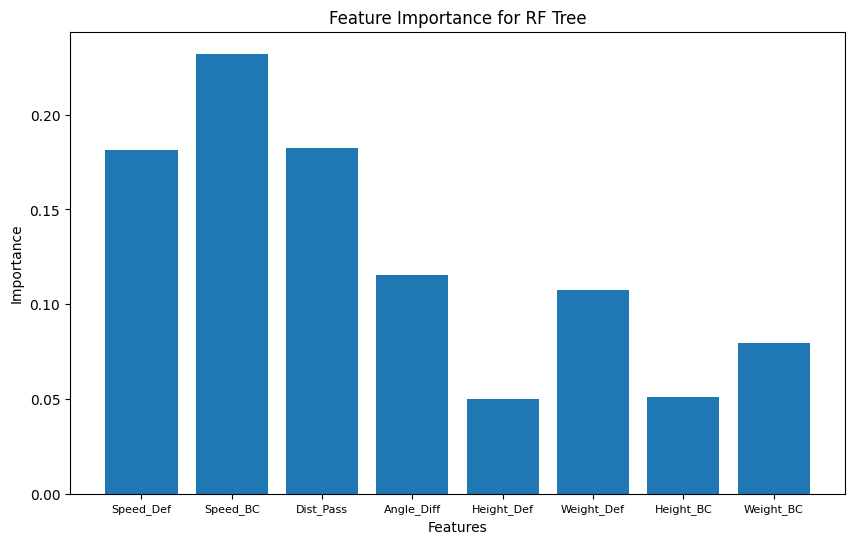

In [107]:
# Getting feature importances
feature_importances = rf_model.feature_importances_

# Creating a bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
plt.bar(X_columns, feature_importances)
custom_labels = ['Speed_Def', 'Speed_BC', 'Dist_Pass', 'Angle_Diff', 'Height_Def', 'Weight_Def', 'Height_BC', 'Weight_BC']
plt.xticks(X_columns, custom_labels, fontsize=8)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance for RF Tree')
plt.show()

## Boosting Regression

In [85]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Assuming your data is stored in a DataFrame named 'yac_df'
# Selecting features (X) and target variable (y)
X_columns = ['avg_speed_defender', 'avg_speed_ballcarrier', 'distance_when_pass_caught',
             'angle_difference', 'defender_height', 'defender_weight',
             'offense_height', 'offense_weight']

y_column = 'yards_after_contact'

X = yac_df[X_columns]
y = yac_df[y_column]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a Gradient Boosting regressor model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Training the model
gb_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_gb = gb_model.predict(X_test)

# Evaluating the model
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'Mean Squared Error (Gradient Boosting): {mse_gb}')
print(f'R-squared (Gradient Boosting): {r2_gb}')


Mean Squared Error (Gradient Boosting): 7.753327678241981
R-squared (Gradient Boosting): -0.023280623669858835


## Feature importance Boosting

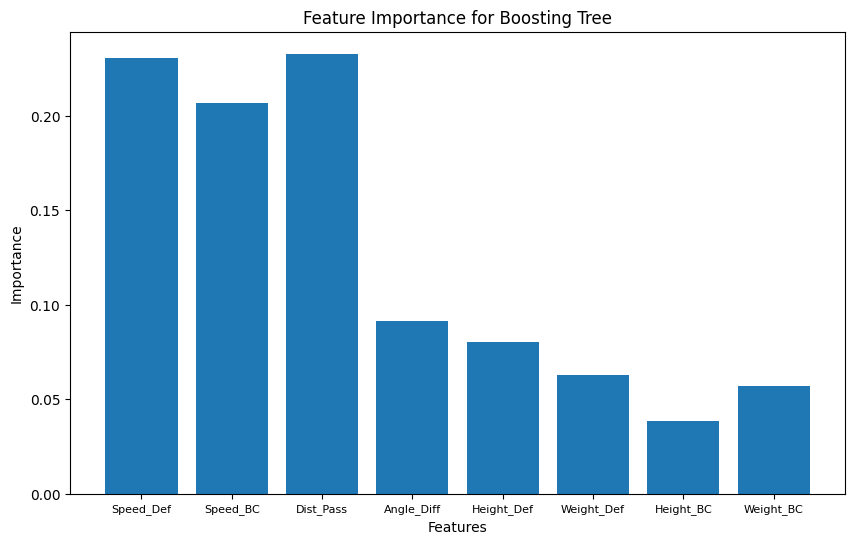

In [86]:
# Getting feature importances
feature_importances = gb_model.feature_importances_

# Creating a bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
plt.bar(X_columns, feature_importances)
custom_labels = ['Speed_Def', 'Speed_BC', 'Dist_Pass', 'Angle_Diff', 'Height_Def', 'Weight_Def', 'Height_BC', 'Weight_BC']
plt.xticks(X_columns, custom_labels, fontsize=8)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance for Boosting Tree')
plt.show()

## K-fold cross validation for Boosting

In [87]:
from sklearn.model_selection import cross_val_score, KFold

# Assuming your data is stored in a DataFrame named 'yac_df'
# Selecting features (X) and target variable (y)
X_columns = ['avg_speed_defender', 'avg_speed_ballcarrier', 'distance_when_pass_caught',
             'angle_difference', 'defender_height', 'defender_weight',
             'offense_height', 'offense_weight']

y_column = 'yards_after_contact'

X = yac_df[X_columns]
y = yac_df[y_column]

# Creating a Gradient Boosting regressor model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(gb_model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Calculate mean squared error from negative scores
mse_cv = -cv_scores.mean()

print(f'Mean Squared Error (Cross-Validated Gradient Boosting): {mse_cv}')


Mean Squared Error (Cross-Validated Gradient Boosting): 11.900131289128874


# Refreame the problem to be binary classification, did he break the tackle or not

## Logistic Regression

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Selecting features (X) and target variable (y)
X_columns = ['avg_speed_defender', 'avg_speed_ballcarrier', 'distance_when_pass_caught',
             'angle_difference', 'defender_height', 'defender_weight', 'offense_height', 'offense_weight']

y_column = 'broken_tackle'

X = yac_df[X_columns]
y = yac_df[y_column]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a logistic regression model
logistic_model = LogisticRegression()

# Training the model
logistic_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_logistic = logistic_model.predict(X_test)

# Evaluating the logistic regression model
accuracy = accuracy_score(y_test, y_pred_logistic)
conf_matrix = confusion_matrix(y_test, y_pred_logistic)
class_report = classification_report(y_test, y_pred_logistic)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


Accuracy: 0.9507575757575758
Confusion Matrix:
[[753   0]
 [ 39   0]]
Classification Report:
              precision    recall  f1-score   support

       False       0.95      1.00      0.97       753
        True       0.00      0.00      0.00        39

    accuracy                           0.95       792
   macro avg       0.48      0.50      0.49       792
weighted avg       0.90      0.95      0.93       792



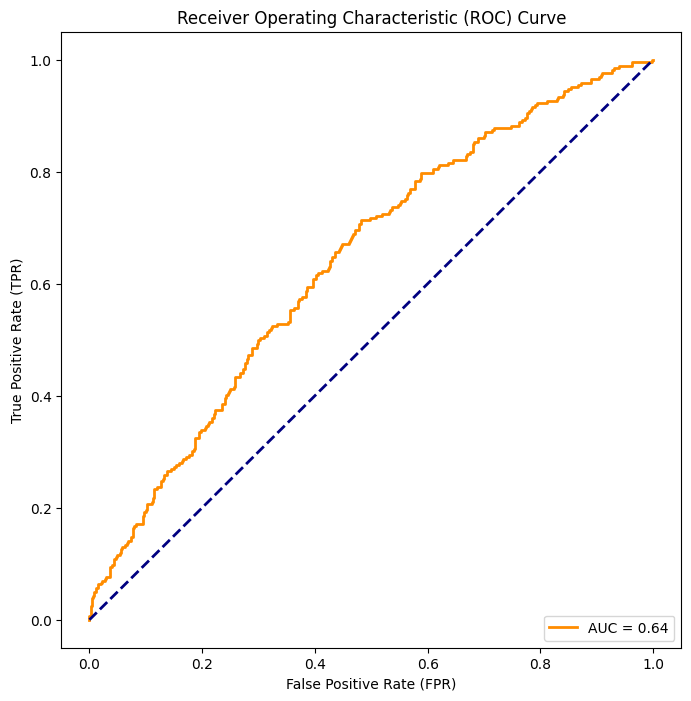

In [89]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (broken_tackle = True)
y_prob_logistic = logistic_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logistic)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## RF Binary

In [99]:
from sklearn.ensemble import RandomForestClassifier
# Assuming your data is stored in a DataFrame named 'yac_df'
X_columns = ['avg_speed_defender', 'avg_speed_ballcarrier', 'distance_when_pass_caught',
             'angle_difference', 'defender_height', 'defender_weight', 'offense_height', 'offense_weight']

y_column = 'broken_tackle'

X = yac_df[X_columns]
y = yac_df[y_column]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a Random Forest classifier
model_rf = RandomForestClassifier(n_estimators = 100, random_state=42)

# Training the model
model_rf.fit(X_train, y_train)

# Making predictions on the test set
y_pred_rf = model_rf.predict(X_test)

# Print confusion matrix and other metrics
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


[[753   0]
 [ 39   0]]
              precision    recall  f1-score   support

       False       0.95      1.00      0.97       753
        True       0.00      0.00      0.00        39

    accuracy                           0.95       792
   macro avg       0.48      0.50      0.49       792
weighted avg       0.90      0.95      0.93       792



## Boosting Binary

In [101]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Assuming your data is stored in a DataFrame named 'yac_df'
X_columns = ['avg_speed_defender', 'avg_speed_ballcarrier', 'distance_when_pass_caught',
             'angle_difference', 'defender_height', 'defender_weight', 'offense_height', 'offense_weight']

y_column = 'broken_tackle'

X = yac_df[X_columns]
y = yac_df[y_column]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating an AdaBoost classifier
model_adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)

# Training the model
model_adaboost.fit(X_train, y_train)

# Getting the decision function values
decision_values = model_adaboost.decision_function(X_test)

# Set a custom threshold
custom_threshold = 0.5  # Change this value as needed
y_pred_custom_threshold = (decision_values >= custom_threshold).astype(int)

# Print confusion matrix and other metrics
print(confusion_matrix(y_test, y_pred_custom_threshold))
print(classification_report(y_test, y_pred_custom_threshold))


[[506   0]
 [286   0]]
              precision    recall  f1-score   support

       False       0.64      1.00      0.78       506
        True       0.00      0.00      0.00       286

    accuracy                           0.64       792
   macro avg       0.32      0.50      0.39       792
weighted avg       0.41      0.64      0.50       792



In this project, I embarked on a comprehensive analysis of player interactions in football plays, particularly focusing on predicting broken tackles during ball carries. Despite a rigorous exploration involving data preprocessing, feature engineering, and the application of various machine learning models, the results have not yielded a highly accurate predictive model. The challenge lies in the inherent class imbalance, where successful tackles significantly outnumber broken tackles. I've experimented with different techniques, including resampling methods, altering evaluation metrics, and adjusting class weights in the models. However, the quest for an optimal solution persists, and further investigation is essential. Additional strategies, such as advanced feature engineering, experimenting with different algorithms, and seeking domain-specific insights, will be crucial to improving model performance. This project has laid a solid foundation, but its complexity calls for continued exploration and refinement to achieve a more robust and reliable predictive model for broken tackles in football plays.